<a href="https://colab.research.google.com/github/nikishkaaa/Bank_Customer_Churn_Prediction_ML/blob/main/Bank_Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement:
Customer churn is a critical issue for banks, as it directly impacts revenue and growth. This project aims to predict whether a customer will leave the bank using a dataset containing various customer attributes and transaction history. By accurately predicting churn, the bank can implement targeted retention strategies, thereby improving customer satisfaction and reducing loss.

# Installing all libraries and exploring the dataset

In [1]:
!pip install opendatasets --upgrade --quiet

In [55]:
import opendatasets as od
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from process_bank_churn import preprocess_data
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.linear_model import  LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.neighbors import KNeighborsClassifier

In [4]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/data'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dashanikishkina
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 63.8MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu/bank-customer-churn-prediction-dlu.zip to ./bank-customer-churn-prediction-dlu


In [5]:
raw_data = pd.read_csv('bank-customer-churn-prediction-dlu/train.csv')
raw_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [7]:
raw_data.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.569146e+07,658.944133,37.739600,5.025267,42729.791988,1.590933,0.788800,0.489667,117784.666193,0.203467
std,4330.271354,1.352050e+05,72.255926,8.218363,2.776678,59727.309419,0.532306,0.408174,0.499910,45734.445888,0.402590
min,0.000000,1.581102e+06,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,3749.750000,1.563514e+07,603.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,83058.140000,0.000000
50%,7499.500000,1.569018e+07,662.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123584.870000,0.000000
75%,11249.250000,1.575718e+07,708.000000,42.000000,7.000000,109531.017500,2.000000,1.000000,1.000000,156884.705000,0.000000
max,14999.000000,1.581569e+07,850.000000,74.000000,10.000000,209767.310000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [8]:
pal = sns.color_palette("Spectral")
sns.set_palette(pal)

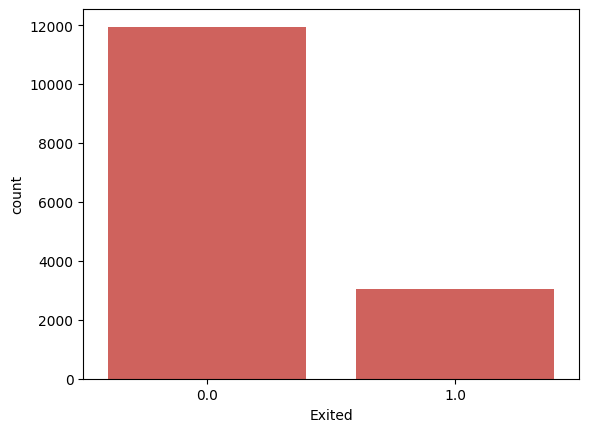

In [9]:
sns.countplot(x = 'Exited', data=raw_data)
plt.show()

In [10]:
numeric_cols = [
 'Age',
 'Balance',
 'CreditScore',
 'IsActiveMember',
 'EstimatedSalary']
categorical_cols = ['Geography', 'Gender','NumOfProducts' ]

## Splitting to train and test using .py file with preprocessing

In [11]:
data =  preprocess_data(raw_data, 'Exited', scaler_numeric=True, categorical_cols=categorical_cols,numeric_cols = numeric_cols)
X_train = data['X_train']
y_train = data['train_targets']
X_val = data['X_val']
y_val= data['val_targets']

# Logistic Regression

In [35]:
model = LogisticRegression(solver = 'liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [36]:
trains_pred = model.predict(X_train)
trains_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [37]:
val_preds = model.predict(X_val)
val_preds

array([1., 0., 0., ..., 0., 0., 0.])

### Confusion matrix

In [38]:
confusion_matrix(y_train, trains_pred)

array([[9140,  418],
       [ 862, 1580]])

In [39]:
confusion_matrix(y_val, val_preds)

array([[2267,  123],
       [ 207,  403]])

#### ROC Curve + AUROC

In [12]:
def compute_auroc_and_build_roc(model, inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1.0)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

In [41]:
y_pred_proba = model.predict_proba(X_train)[:, 1]
y_pred_proba

array([0.01510262, 0.22376945, 0.04143792, ..., 0.00316166, 0.06918303,
       0.02094629])

In [42]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba, pos_label=1.0)
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , ..., 0.99466416, 0.99466416,
        1.        ]),
 array([0.00000000e+00, 4.09500410e-04, 3.35790336e-02, ...,
        9.99590500e-01, 1.00000000e+00, 1.00000000e+00]),
 array([           inf, 9.99613430e-01, 9.87036153e-01, ...,
        1.10269073e-03, 1.09444579e-03, 3.51498278e-04]))

AUROC for Training: 0.93


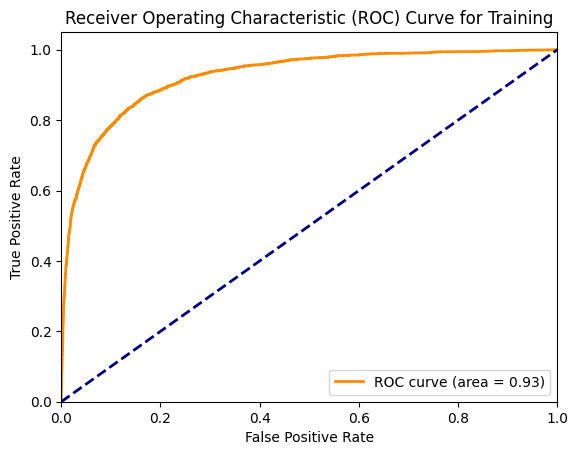

AUROC for Validation: 0.92


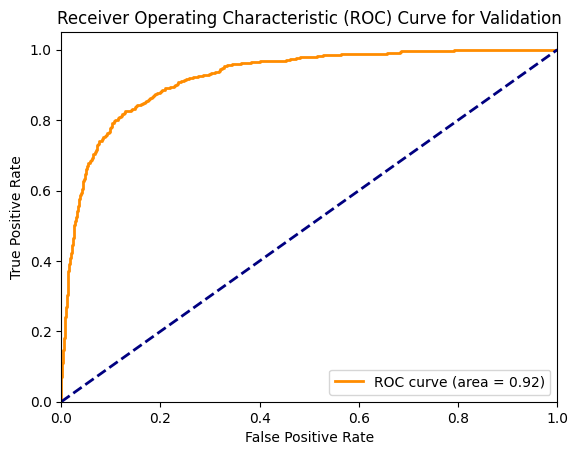

In [43]:
compute_auroc_and_build_roc(model, X_train, y_train, 'Training')
compute_auroc_and_build_roc(model, X_val, y_val, 'Validation')

#### Conclusion: The model performs very well, as AUROC = 0.92, and the difference between the metric scores for the training and validation datasets is minimal.

# SVM

In [46]:
svm = SVC(kernel='sigmoid', probability=True)
svm.fit(X_train, y_train)

train_preds = svm.predict(X_train)
test_preds = svm.predict(X_val)

AUROC for Training: 0.75


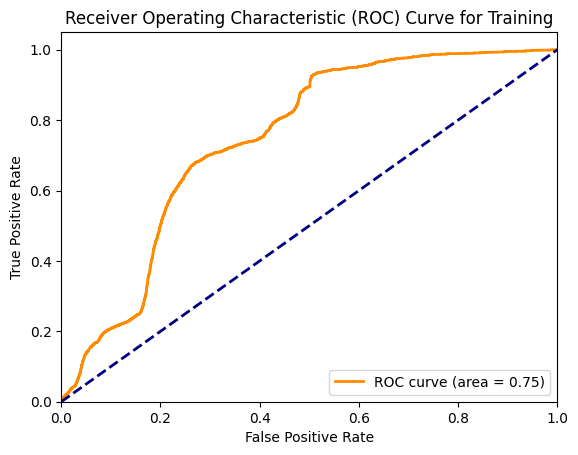

AUROC for Validation: 0.75


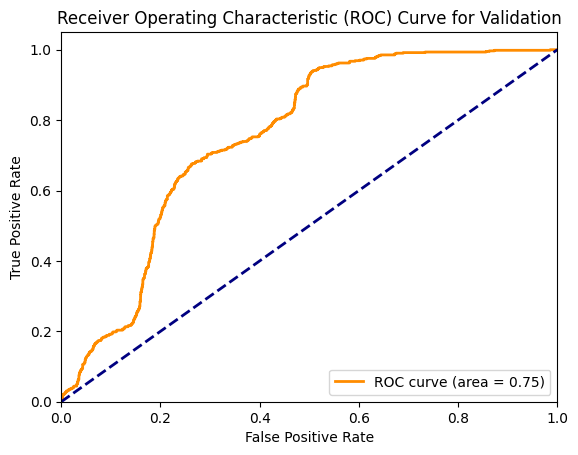

In [47]:
compute_auroc_and_build_roc(svm, X_train, y_train, 'Training')
compute_auroc_and_build_roc(svm, X_val, y_val, 'Validation')

#### Best hyperparameters searching with GridSearchCV

In [50]:
svm_model = SVC(probability=True)

param_grid = {
    'kernel': ['sigmoid', 'linear', 'poly', 'rbf']
}

grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best AUROC score: ", grid_search.best_score_)


best_model = grid_search.best_estimator_


train_preds = best_model.predict_proba(X_train)[:, 1]
test_preds = best_model.predict_proba(X_val)[:, 1]

print('Train AUROC =', roc_auc_score(y_train, train_preds))
print('Test AUROC =', roc_auc_score(y_val, test_preds))

Best parameters found:  {'kernel': 'linear'}
Best AUROC score:  0.9239781236082475
Train AUROC = 0.9245296914788441
Test AUROC = 0.9203861718910762


#### Conclusion: GridSearchCV found the best hyperparameters for SVM model. So, the model performs very well, as AUROC = 0.92, and the difference between the metric scores for the training and validation datasets is minimal.

# Decision Tree

In [14]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

AUROC for Trainig: 1.00


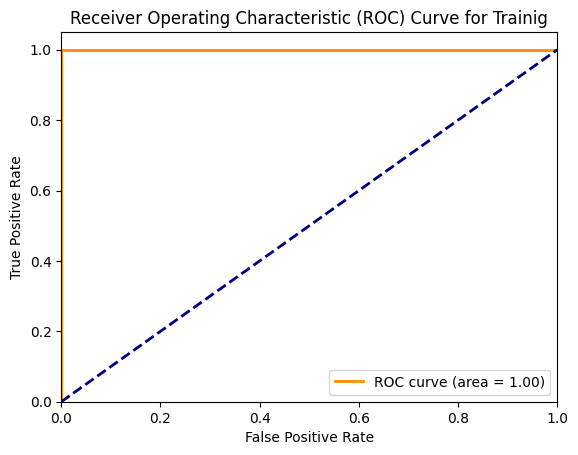

AUROC for Validation: 0.77


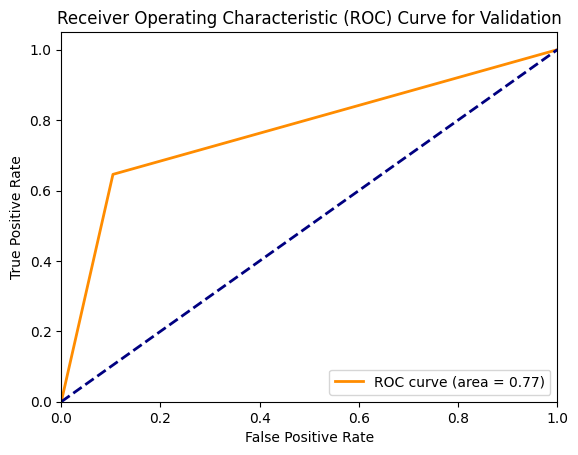

In [15]:
compute_auroc_and_build_roc(model, X_train, y_train, 'Trainig')
compute_auroc_and_build_roc(model, X_val, y_val, 'Validation')

#### Conclusion: The Decision Tree model, without hyperparameter tuning, has overfit the training data.

In [16]:
model.tree_.max_depth

28

In [18]:
model_2 = DecisionTreeClassifier(max_depth=2, random_state=42)
model_2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [19]:
model_2.feature_importances_.round(2)
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance' : model_2.feature_importances_.round(2)
})
importance_df.sort_values('importance', ascending = False)

,feature,importance
0,Age,0.64
11,NumOfProducts_2.0,0.36
1,Balance,0.00
2,CreditScore,0.00
3,IsActiveMember,0.00
4,EstimatedSalary,0.00
5,Geography_France,0.00
6,Geography_Germany,0.00
7,Geography_Spain,0.00
8,Gender_Female,0.00


We have 2 import features: Age	and NumOfProducts_2.0

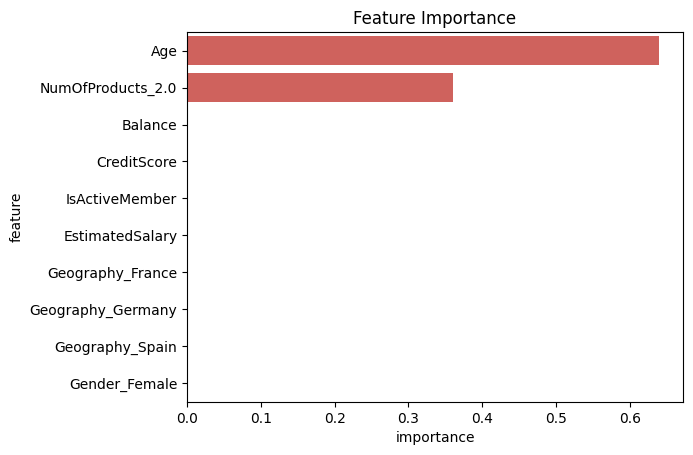

In [20]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.sort_values('importance', ascending = False).head(10), x='importance', y='feature');

AUROC for Trainig: 0.86


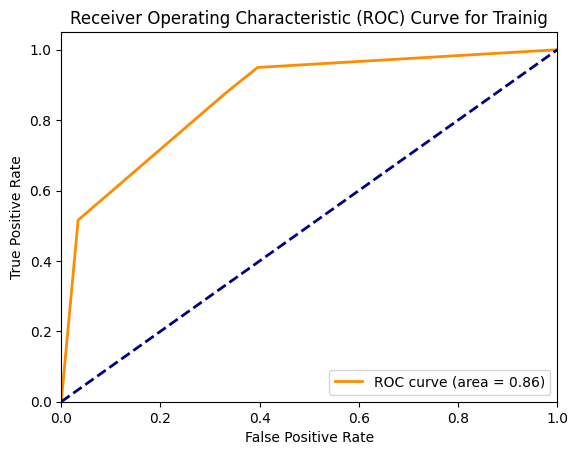

AUROC for Validation: 0.86


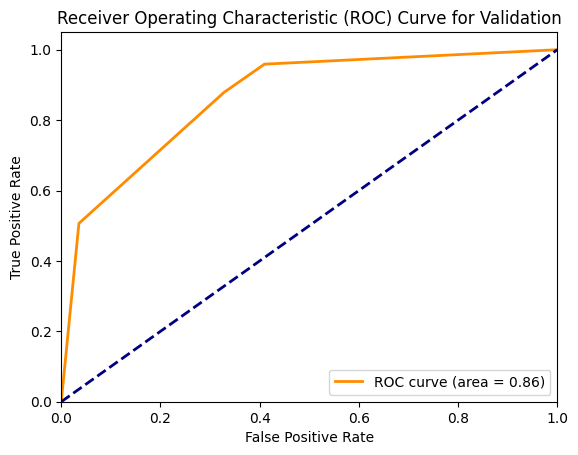

In [21]:
model3 = DecisionTreeClassifier(random_state=42, max_depth=2)
model3.fit(X_train, y_train)
compute_auroc_and_build_roc(model3, X_train, y_train, 'Trainig')
compute_auroc_and_build_roc(model3, X_val, y_val, 'Validation')

AUROC for Trainig: 0.92


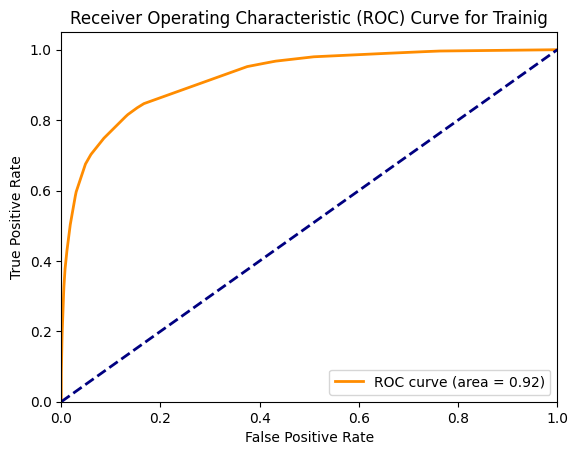

AUROC for Validation: 0.92


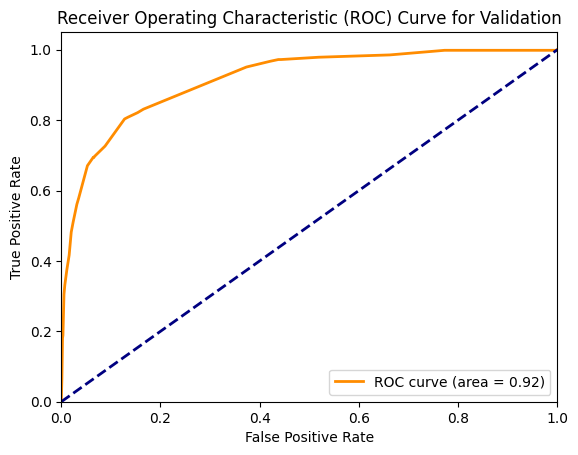

In [22]:
model4 = DecisionTreeClassifier(random_state=42, max_depth=5)
model4.fit(X_train, y_train)
compute_auroc_and_build_roc(model4, X_train, y_train, 'Trainig')
compute_auroc_and_build_roc(model4, X_val, y_val, 'Validation')

In [23]:
def compute_roc_auc(model, df, target, name=''):
  preds = model.predict(df)
  fpr, tpr, thresholds = roc_curve(target, preds, pos_label=1.0)
  roc_auc = auc(fpr, tpr)
  return roc_auc


In [25]:
for max_depth in range(1,21):
  model = DecisionTreeClassifier(random_state=42, max_depth= max_depth)
  model.fit(X_train, y_train)
  print( 'Train with max_depth =', max_depth, ' AUROC =', compute_roc_auc(model, X_train, y_train, name='Train'))
  print('Validation with max_depth =', max_depth, ' AUROC =', compute_roc_auc(model, X_val, y_val, name='Validation'))
  print(' ')


Train with max_depth = 1  AUROC = 0.7447268789076699
Validation with max_depth = 1  AUROC = 0.7348652170930791
 
Train with max_depth = 2  AUROC = 0.7409837932436802
Validation with max_depth = 2  AUROC = 0.7354962617463475
 
Train with max_depth = 3  AUROC = 0.7409837932436802
Validation with max_depth = 3  AUROC = 0.7354962617463475
 
Train with max_depth = 4  AUROC = 0.8126948211693974
Validation with max_depth = 4  AUROC = 0.8083990671513822
 
Train with max_depth = 5  AUROC = 0.8132556028036254
Validation with max_depth = 5  AUROC = 0.8088860690033611
 
Train with max_depth = 6  AUROC = 0.8185391349233158
Validation with max_depth = 6  AUROC = 0.8058851773098292
 
Train with max_depth = 7  AUROC = 0.8290292089727117
Validation with max_depth = 7  AUROC = 0.7949859386789218
 
Train with max_depth = 8  AUROC = 0.8350479395677136
Validation with max_depth = 8  AUROC = 0.7939742094793881
 
Train with max_depth = 9  AUROC = 0.8634244156843028
Validation with max_depth = 9  AUROC = 0.81

### Searching for best score

In [28]:
dt = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid,
                           scoring='roc_auc', cv=5, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Evaluate the best model on the test set
y_pred_proba = best_estimator.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print("AUC-ROC on Test Set:", roc_auc)
print("Classification Report:\n", classification_report(y_val, best_estimator.predict(X_val)))

Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
AUC-ROC on Test Set: 0.9157160984978394
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.95      0.93      2390
         1.0       0.77      0.64      0.70       610

    accuracy                           0.89      3000
   macro avg       0.84      0.79      0.81      3000
weighted avg       0.88      0.89      0.88      3000



#### Conclusion: The model performs very well, as AUROC = 0.92.

# XGBClassifier

In [30]:
def categorise(categorical_cols:list, df):
  for col in categorical_cols:
    df[col] = df[col].astype('category')
  return df

In [34]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_val.select_dtypes(exclude=[np.number]).columns.tolist()

In [35]:
train_inputs = categorise(categorical_cols, X_train)
val_inputs = categorise(categorical_cols, X_val)

In [37]:
xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators=10,
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cuda'
)

xgb_clf.fit(X_train, y_train)
train_preds = xgb_clf.predict(X_train)
val_preds = xgb_clf.predict(val_inputs)

print("Train AUROC", roc_auc_score(y_train, train_preds))
print("Val AUROC", roc_auc_score(y_val, val_preds))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:00:32] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:00:32] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:00:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Train AUROC 0.8077919984699646
Val AUROC 0.8030420467796144


In [39]:
# Computes ROC AUC
def compute_auroc(model, inputs, targets):
  y_pred = model.predict_proba(inputs)[:, 1]

  return roc_auc_score(targets, y_pred)


# Specifies objective
def objective(model_class, param_space, params, **model_specific_params):
    # Convert hyperopt params to the correct types if necessary
    model_params = {key: int(value) if key in param_space['int_params'] else value for key, value in params.items()}

    # Initialize the model with enable_categorical if using XGBClassifier
    if model_class == XGBClassifier:
        model = model_class(**model_params, enable_categorical=True, **model_specific_params, random_state=42)
    else:
        model = model_class(**model_params, **model_specific_params, random_state=42)

    # Fit the model
    try:
        model.fit(train_inputs, y_train, eval_set=[(val_inputs, y_val)], verbose=False)
    except TypeError:
        model.fit(train_inputs, y_train, eval_set=[(val_inputs, y_val)])

    # Compute the AUROC
    auroc = compute_auroc(model, val_inputs, y_val)

    return {'loss': -auroc, 'status': STATUS_OK}

# Wrapper function for hyperopt for XGB
def hyperopt_objective_XGB(params):
    return objective(XGBClassifier, param_space, params, device='cuda')


# Function to find best hyperparameters
def optimize_hyperopt_params(objective, space, int_params, max_evals):
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=Trials())
    # Convert hyperparameter values to final types
    for key in int_params:
      best[key] = int(best[key])

    print("Best hyperparameters: ", best)

    return best

In [43]:
param_space = {
    'params': {
        # The number of boosting rounds (trees) to build
        'n_estimators': hp.quniform('n_estimators', 50, 500, 50),
        # The learning rate, which controls the contribution of each tree to the final model
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
        # The maximum depth of a tree
        'max_depth': hp.quniform('max_depth', 3, 10, 1),
        # Minimum sum of instance weight (hessian) needed in a child
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        # The fraction of samples to be used for building each tree
        'subsample': hp.uniform('subsample', 0.6, 1.0),
        # The fraction of features to be used for building each tree
        'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
        # Minimum loss reduction required to make a further partition on a leaf node of the tree
        'min_split_loss': hp.uniform('min_split_loss', 0, 0.5),
        # L1 regularization term on weights
        'reg_alpha': hp.uniform('reg_alpha', 0.001, 1),
        # L2 regularization term on weights
        'reg_lambda': hp.uniform('reg_lambda', 0.001, 1)
    },
    'int_params': ['n_estimators', 'max_depth', 'min_child_weight']
}

# Find best hyperparameters for XGB Classifier
best = optimize_hyperopt_params(hyperopt_objective_XGB, param_space['params'], param_space['int_params'], max_evals=10)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:40] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:40] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 10%|█         | 1/10 [00:10<01:30, 10.02s/trial, best loss: -0.9216311132450784]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:49] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:49] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 20%|██        | 2/10 [00:11<00:37,  4.71s/trial, best loss: -0.9317456615680086]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:50] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:50] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 30%|███       | 3/10 [00:11<00:18,  2.69s/trial, best loss: -0.9348621304616229]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:51] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:51] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 40%|████      | 4/10 [00:11<00:11,  1.87s/trial, best loss: -0.9356649975992866]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:51] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:51] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 50%|█████     | 5/10 [00:12<00:07,  1.52s/trial, best loss: -0.9356649975992866]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:52] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:52] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 60%|██████    | 6/10 [00:14<00:06,  1.65s/trial, best loss: -0.9356649975992866]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:54] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:54] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 70%|███████   | 7/10 [00:15<00:03,  1.29s/trial, best loss: -0.9356649975992866]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 80%|████████  | 8/10 [00:18<00:03,  1.87s/trial, best loss: -0.9356649975992866]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:58] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:58] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



 90%|█████████ | 9/10 [00:19<00:01,  1.77s/trial, best loss: -0.9356649975992866]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:59] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:18:59] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)



100%|██████████| 10/10 [00:20<00:00,  2.08s/trial, best loss: -0.9356649975992866]
Best hyperparameters:  {'colsample_bytree': 0.9494982601191133, 'learning_rate': 0.020384802030056836, 'max_depth': 6, 'min_child_weight': 2, 'min_split_loss': 0.12142908951322906, 'n_estimators': 150, 'reg_alpha': 0.7832361612551209, 'reg_lambda': 0.32073179102335625, 'subsample': 0.6545896860035539}


In [45]:
# Final model with the best parameters
final_clf_xgb = XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    min_split_loss=best['min_split_loss'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    random_state=42,
    device='cuda',
    enable_categorical=True
)

final_clf_xgb.fit(X_train, y_train)

print('Train AUROC', compute_auroc(final_clf_xgb, X_train, y_train))
print('Validation AUROC', compute_auroc(final_clf_xgb, X_val, y_val))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:19:44] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:19:44] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Train AUROC 0.9501430680809211
Validation AUROC 0.9356649975992866


### Conclusion: The model performs very well, as AUROC = 0.95 on train data and 0.93 on test data.

# KNN

In [50]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
train_preds = knn.predict(X_train)
test_preds = knn.predict(X_val)

print("Train ROC AUC", roc_auc_score(y_train, train_preds))
print("Val ROC AUC", roc_auc_score(y_val, test_preds))

Train ROC AUC 0.8401217087657766
Val ROC AUC 0.7822038548597298


### Searching the best parameters with GridSearchCV

In [52]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 9, 10, 12],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}


def grid_search(param_grid, estimator):
        grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid,
                                  scoring='roc_auc', cv=5, verbose=0, n_jobs=-1)

        grid_search.fit(X_train, y_train)
        best = grid_search.best_estimator_
        best_predictions_train = best.predict(X_train)
        best_predictions_test = best.predict(X_val)

        print("Best params: ", grid_search.best_params_)
        print("Best AUROC for Train: ", roc_auc_score(y_train, best_predictions_train ))
        print("Best AUROC for Test: ", roc_auc_score(y_val, best_predictions_test))
        return best
grid_search(param_grid, knn)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best params:  {'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'uniform'}
Best AUROC for Train:  0.7984814552611164
Best AUROC for Test:  0.7685986693188833


KNeighborsClassifier(metric='manhattan', n_neighbors=12)

### Searching the best parameters with Random Search

In [53]:
random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_grid,
                                              n_iter=40, scoring='roc_auc', cv=3, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)
best = random_search.best_estimator_
best_predictions_train = best.predict(X_train)
best_predictions_test = best.predict(X_val)

print("Best params: ", random_search.best_params_)
print("Best AUROC for Train: ", roc_auc_score(y_train, best_predictions_train ))
print("Best AUROC for Test: ", roc_auc_score(y_val, best_predictions_test))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=40. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best params:  {'weights': 'distance', 'n_neighbors': 12, 'metric': 'manhattan'}
Best AUROC for Train:  1.0
Best AUROC for Test:  0.7871733315042184


### Conclusion: KNN model demonstrates a high training score of 1.0, indicating that the model perfectly fits the training data. However, the significantly lower test score of 0.78 suggests that the model is overfitting. This means that while KNN can accurately classify the training examples, it struggles to generalize to unseen data.

### Implementing cross-validation during training to better assess the model's performance and mitigate overfitting

In [56]:
knn = KNeighborsClassifier(weights= 'distance', n_neighbors=12, metric ='manhattan')


cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='roc_auc')

print("Cross-Validation AUC-ROC Scores:", cv_scores)
print("Mean Cross-Validation AUC-ROC Score:", cv_scores.mean())

knn.fit(X_train, y_train)

y_pred_proba = knn.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_proba)
print("AUC-ROC on Test Set:", roc_auc)
print("Classification Report:\n", classification_report(y_val, knn.predict(X_val)))


Cross-Validation AUC-ROC Scores: [0.91405393 0.88729026 0.90965923 0.90729166 0.91824856]
Mean Cross-Validation AUC-ROC Score: 0.9073087266500168
AUC-ROC on Test Set: 0.9037677481308731
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.95      0.93      2390
         1.0       0.75      0.63      0.68       610

    accuracy                           0.88      3000
   macro avg       0.83      0.79      0.81      3000
weighted avg       0.88      0.88      0.88      3000



### KNN model yielded an impressive AUC-ROC score of 0.9. This indicates that the model performs well